In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import time 


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [2]:
mnist_train = pd.read_csv(r"/kaggle/input/mnist-in-csv/mnist_train.csv")
mnist_test = pd.read_csv(r"/kaggle/input/mnist-in-csv/mnist_test.csv")

In [3]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_file = open(r"/kaggle/input/mnist-in-csv/mnist_train.csv")
train_list = train_file.readlines()
train_file.close()
test_file = open(r"/kaggle/input/mnist-in-csv/mnist_test.csv")
test_list = test_file.readlines()
test_file.close()

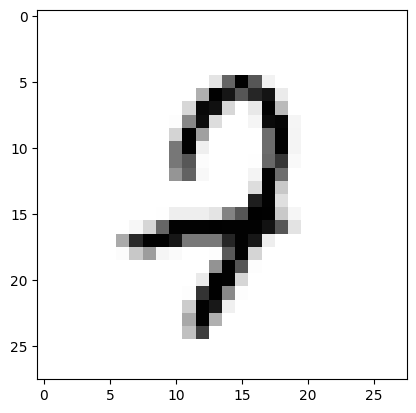

In [6]:
# 150th value in the train data
values = train_list[149].split(",")
img_arr = np.asarray(values[1:], dtype="float").reshape((28,28))
plt.imshow(img_arr, cmap="Grays", interpolation="None")

In [7]:
class DNN:
    def __init__(self, sizes=[784, 128, 64, 10], epochs=10, learning_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        input_layer = sizes[0]
        hidden_1 = sizes[1]
        hidden_2 = sizes[2]
        output_layer = sizes[3]
        
        self.params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1./hidden_1),       #128*784 
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1./hidden_2),          #64*128
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1./output_layer),  #10*64
        }

    
    def sigmoid(self, x, derivative=False):
        if (derivative):
            return ((np.exp(-x))/(np.exp(-x)+1)**2)
        else: 
            return 1/(1+np.exp(-x))

    
    def softmax(self, x, derivative=False):
        exps = np.exp(x-x.max())
        if (derivative):
            return exps / np.sum(exps, axis=0)*(1-exps/np.sum(exps, axis=0))
        else:
            return exps / np.sum(exps, axis=0)

    
    def forward_pass(self, x_train):
        params = self.params
        params["A0"] = x_train
        
        #input_layer to hidden_1
        params["Z1"] = np.dot(params["W1"], params["A0"])
        params["A1"] = self.sigmoid(params["Z1"])
        
        #hidden_1 to hidden_2
        params["Z2"] = np.dot(params["W2"], params["A1"])
        params["A2"] = self.sigmoid(params["Z2"])
        
        #hidden_2 to output
        params["Z3"] = np.dot(params["W3"], params["A2"])
        params["A3"] = self.softmax(params["Z3"])
        
        return params["Z3"]
        

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}
        
        error = 2 * (output-y_train) / output.shape[0] * self.softmax(params["Z3"], derivative = True)
        change_w["W3"] = np.outer(error, params["A2"])
        
        error = np.dot(params["W3"].T, error) * self.sigmoid(params["Z2"], derivative = True)
        change_w["W2"] = np.outer(error, params["A1"])
        
        error = np.dot(params["W2"].T, error) * self.sigmoid(params["Z1"], derivative = True)
        change_w["W1"] = np.outer(error, params["A0"])
        
        return change_w

    
    def update_weights(self, change_w):
        for key, val in change_w.items():
            self.params[key] -= self.learning_rate* val 
        
    
    def compute_accuracy(self, test_data):
        predictions = []
        for x in test_data[1:]:
            values = x.split(",")
            inputs = (np.asarray(values[1:], dtype="float")/255.0*0.99) + 0.01
            targets = np.zeros(10) + 0.01
            targets[int(values[0])] = 0.99
            output = self.forward_pass(inputs)
            pred = np.argmax(output)
            predictions.append(pred==np.argmax(targets))
            
        return np.mean(predictions)

    def train(self, train_list, test_list):
        for i in range(self.epochs):
            start_time = time.time()
            for x in train_list[1:]:
                values = x.split(",")
                # print(values)
                inputs = (np.asarray(values[1:], dtype="float")/255.0*0.99) + 0.01
                targets = np.zeros(10) + 0.01
                targets[int(values[0])] = 0.99
                output = self.forward_pass(inputs)
                change_w = self.backward_pass(targets, output)
                self.update_weights(change_w)
                
            accuracy = self.compute_accuracy(test_list)
            print("Epoch: {0}, Time Spent: {1:.02f}s, Accuracy: {2:.2f}%".format(i+1, time.time()-start_time, accuracy*100))

In [8]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=30, learning_rate=0.01)
dnn.train(train_list, test_list)

Epoch: 1, Time Spent: 44.13s, Accuracy: 71.65%
Epoch: 2, Time Spent: 44.67s, Accuracy: 79.55%
Epoch: 3, Time Spent: 43.02s, Accuracy: 82.45%
Epoch: 4, Time Spent: 42.84s, Accuracy: 83.76%
Epoch: 5, Time Spent: 46.23s, Accuracy: 84.61%
Epoch: 6, Time Spent: 45.82s, Accuracy: 85.14%
Epoch: 7, Time Spent: 45.08s, Accuracy: 85.75%
Epoch: 8, Time Spent: 45.17s, Accuracy: 86.21%
Epoch: 9, Time Spent: 44.58s, Accuracy: 86.54%
Epoch: 10, Time Spent: 44.96s, Accuracy: 86.91%
Epoch: 11, Time Spent: 43.77s, Accuracy: 87.15%
Epoch: 12, Time Spent: 44.04s, Accuracy: 87.50%
Epoch: 13, Time Spent: 46.66s, Accuracy: 87.67%
Epoch: 14, Time Spent: 48.29s, Accuracy: 88.05%
Epoch: 15, Time Spent: 45.72s, Accuracy: 88.24%
Epoch: 16, Time Spent: 42.64s, Accuracy: 88.46%
Epoch: 17, Time Spent: 43.63s, Accuracy: 88.74%
Epoch: 18, Time Spent: 43.49s, Accuracy: 88.97%
Epoch: 19, Time Spent: 43.68s, Accuracy: 89.26%
Epoch: 20, Time Spent: 43.04s, Accuracy: 89.48%
Epoch: 21, Time Spent: 43.87s, Accuracy: 89.65%
E